In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ast
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import normalize
from keras.preprocessing import image
from time import time
from scipy.spatial.distance import cosine, euclidean, hamming

In [3]:
# Đọc file CSV
recipe = pd.read_csv('data/raw-data_recipe.csv')
recipe = recipe.drop(columns=['cooking_directions', 'reviews'])
recipe.head(3)
print(recipe.shape)

(49698, 7)


In [4]:
def avg_rate(col):
    return f'{col:.2f}'
recipe.aver_rate = recipe.aver_rate.apply(avg_rate)
recipe.aver_rate = recipe.aver_rate.astype(float)
recipe.dtypes

recipe_id        int64
recipe_name     object
aver_rate      float64
image_url       object
review_nums      int64
ingredients     object
nutritions      object
dtype: object

In [5]:

list_of_nutition = []

for row in recipe.nutritions:
    list_of_nutition.append(ast.literal_eval(row))
print(list_of_nutition[1])

{'niacin': {'hasCompleteData': False, 'name': 'Niacin Equivalents', 'amount': 15.6016, 'percentDailyValue': '120', 'displayValue': '16', 'unit': 'mg'}, 'sugars': {'hasCompleteData': False, 'name': 'Sugars', 'amount': 19.84146, 'percentDailyValue': '0', 'displayValue': '19.8', 'unit': 'g'}, 'sodium': {'hasCompleteData': False, 'name': 'Sodium', 'amount': 2606.764, 'percentDailyValue': '104', 'displayValue': '2607', 'unit': 'mg'}, 'carbohydrates': {'hasCompleteData': True, 'name': 'Carbohydrates', 'amount': 32.08176, 'percentDailyValue': '10', 'displayValue': '32.1', 'unit': 'g'}, 'vitaminB6': {'hasCompleteData': False, 'name': 'Vitamin B6', 'amount': 1.328631, 'percentDailyValue': '83', 'displayValue': '1', 'unit': 'mg'}, 'calories': {'hasCompleteData': True, 'name': 'Calories', 'amount': 371.7219, 'percentDailyValue': '19', 'displayValue': '372', 'unit': 'kcal'}, 'thiamin': {'hasCompleteData': False, 'name': 'Thiamin', 'amount': 0.8423121, 'percentDailyValue': '84', 'displayValue': '< 

In [6]:

#  Trích xuất các giá trị daily values cho các chất dinh dưỡng được chọn
calories_list = []
fat_list = []
carbohydrates_list = []
protein_list = []
cholesterol_list = []
sodium_list = []
fiber_list = []

for x in range(len(list_of_nutition)):
    calories_list.append(list_of_nutition[x]['calories']['percentDailyValue'])
    fat_list.append(list_of_nutition[x]['fat']['percentDailyValue'])
    carbohydrates_list.append(list_of_nutition[x]['carbohydrates']['percentDailyValue'])
    protein_list.append(list_of_nutition[x]['protein']['percentDailyValue'])
    cholesterol_list.append(list_of_nutition[x]['cholesterol']['percentDailyValue'])
    sodium_list.append(list_of_nutition[x]['sodium']['percentDailyValue'])
    fiber_list.append(list_of_nutition[x]['fiber']['percentDailyValue'])
    
    
# group all the data into dataframe
data = {'calories': calories_list, 'fat': fat_list, 'carbohydrates': carbohydrates_list, 
       'protein': protein_list, 'cholesterol': cholesterol_list, 'sodium': sodium_list, 
       'fiber': fiber_list}

df = pd.DataFrame(data)
df.index = recipe['recipe_id']
df.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,15,36,< 1,42,21,81,2
240488,19,18,10,73,33,104,41
218939,17,36,2,48,24,31,4
87211,32,45,20,65,20,43,18
245714,8,12,5,14,7,8,3


In [7]:
print(df.shape)
df = df.dropna()
print(df.shape)

(49698, 7)
(48735, 7)


In [8]:
print(df.shape)
df = df.dropna()
def text_cleaning(cols):
    if cols == '< 1':
        return 1
    else:
        return cols

# Dữ liệu percentDailyValue là dạng String và có dữ liệu <1, nên chuyển hết < 1 thành 1
for col in df.columns:
    df[col] = df[col].apply(text_cleaning)
# Chuyển hết thành phần từ String sang số
df = df.apply(pd.to_numeric)
df.head()

(48735, 7)


,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,15,36,1,42,21,81,2
240488,19,18,10,73,33,104,41
218939,17,36,2,48,24,31,4
87211,32,45,20,65,20,43,18
245714,8,12,5,14,7,8,3


In [9]:
df_normalized = pd.DataFrame(normalize(df, axis=0))
df_normalized.columns = df.columns
df_normalized.index = df.index
df_normalized.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560
240488,0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477
218939,0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120
87211,0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039
245714,0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840


In [10]:
recipe_final= pd.merge(recipe, df, on='recipe_id')
recipe_final= recipe_final.drop(columns=['nutritions','image_url'])
recipe_final.head()
# recipe_final.count

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
0,222388,Homemade Bacon,5.00,3,pork belly^smoked paprika^kosher salt^ground b...,15,36,1,42,21,81,2
1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,29,sauerkraut drained^Granny Smith apples sliced^...,19,18,10,73,33,104,41
2,218939,Foolproof Rosemary Chicken Wings,4.57,12,chicken wings^sprigs rosemary^head garlic^oliv...,17,36,2,48,24,31,4
3,87211,Chicken Pesto Paninis,4.62,163,focaccia bread quartered^prepared basil pesto^...,32,45,20,65,20,43,18
4,245714,Potato Bacon Pizza,4.50,2,red potatoes^strips bacon^Sauce:^heavy whippin...,8,12,5,14,7,8,3


In [11]:
ingredients_list = []

for x in range(len(recipe_final)):
    ingredients_list.append(recipe_final['ingredients'][x].split('^'))
data = {'ingredients_list': ingredients_list}
df1 = pd.DataFrame(data)
df1.index = recipe_final['recipe_id']

recipe_final= pd.merge(recipe_final, df1, on='recipe_id')
recipe_final= recipe_final.drop(columns=['ingredients'])

recipe_final.to_csv("recipe_final.csv")

In [12]:
recipe_final.head()

,recipe_id,recipe_name,aver_rate,review_nums,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,ingredients_list
0,222388,Homemade Bacon,5.00,3,15,36,1,42,21,81,2,"[pork belly, smoked paprika, kosher salt, grou..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,29,19,18,10,73,33,104,41,"[sauerkraut drained, Granny Smith apples slice..."
2,218939,Foolproof Rosemary Chicken Wings,4.57,12,17,36,2,48,24,31,4,"[chicken wings, sprigs rosemary, head garlic, ..."
3,87211,Chicken Pesto Paninis,4.62,163,32,45,20,65,20,43,18,"[focaccia bread quartered, prepared basil pest..."
4,245714,Potato Bacon Pizza,4.50,2,8,12,5,14,7,8,3,"[red potatoes, strips bacon, Sauce:, heavy whi..."


recipe_id      87211
calories          32
fat               45
carbohydrates     20
protein           65
cholesterol       20
sodium            43
fiber             18


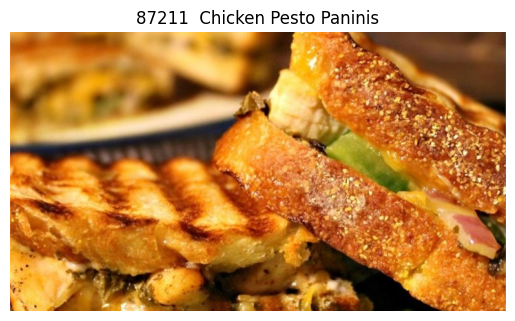

In [14]:
# show recipe id, recipe name and image of selected recipe
def selected_recipe(recipe_id):
    image_path = "raw-data-images/raw-data-images/{}.jpg"
    image_path = image_path.format(recipe_id)
    
    img = image.load_img(image_path)
    img = image.img_to_array(img, dtype='int')
        
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    ax.axis('off')
    
    recipe_df = recipe.set_index('recipe_id')
    x = "{}  {}".format(recipe_id, recipe_df.at[recipe_id, 'recipe_name'])
    ax.set_title(x)
    
    print(df.loc[df.index.isin([recipe_id])].transpose())
    
selected_recipe(87211)